## Predicting COVID-19 on the U.S. County Level

**Author**: Rajiv Shah

**Contributors**: Emily Webber

### Background
With the fight against COVID-19 spreading across the U.S. and the world, DataRobot’s enterprise AI platform has developed models to predict which U.S. counties are likely to have their first confirmed COVID-19 cases in the day. The goal was to help federal, state, and local governments to use this information to budget resources, take preemptive measures and help citizens to take preventive measures. This information also would be very useful to healthcare providers to help prepare their staff with the most accurate information. 

Since releasing this model, we have had many requests to explain our approach and share the code so it can be replicated.  In this post, we will explain the methodology and results of our model.  Also attached to this post is the dataset we used along with a python notebook, so others can replicate and build upon this work.  

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.19.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com

### Initial Approach

After studying the needs of government and the available data, we decided to focus on identifying counties in the US that are likely to have a COVID case.  While we provide a step by step description of how to build the model, like most science, the actual path was a bit more of a zig-zag with some double-backs.  This section goes through how we built the model, the features or variables our models found important for predicting COVID, and how we are continuing to improve the model with new data.

The methodology we used is known as a look-alike model. This is a common approach in marketing, where a data scientist may be presented with data on 10,000 homeowners and be asked to identify 50,000 more homeowners with the same characteristics.  This approach has other names as well from PU (positive-unknown) model or one-class classification.  


### Building the Model
As with all predicting modeling, the starting point is gathering historical data.  We identified which counties currently have a virus detected or not.  As an example, the map below shows confirmed cases by March 16th. 



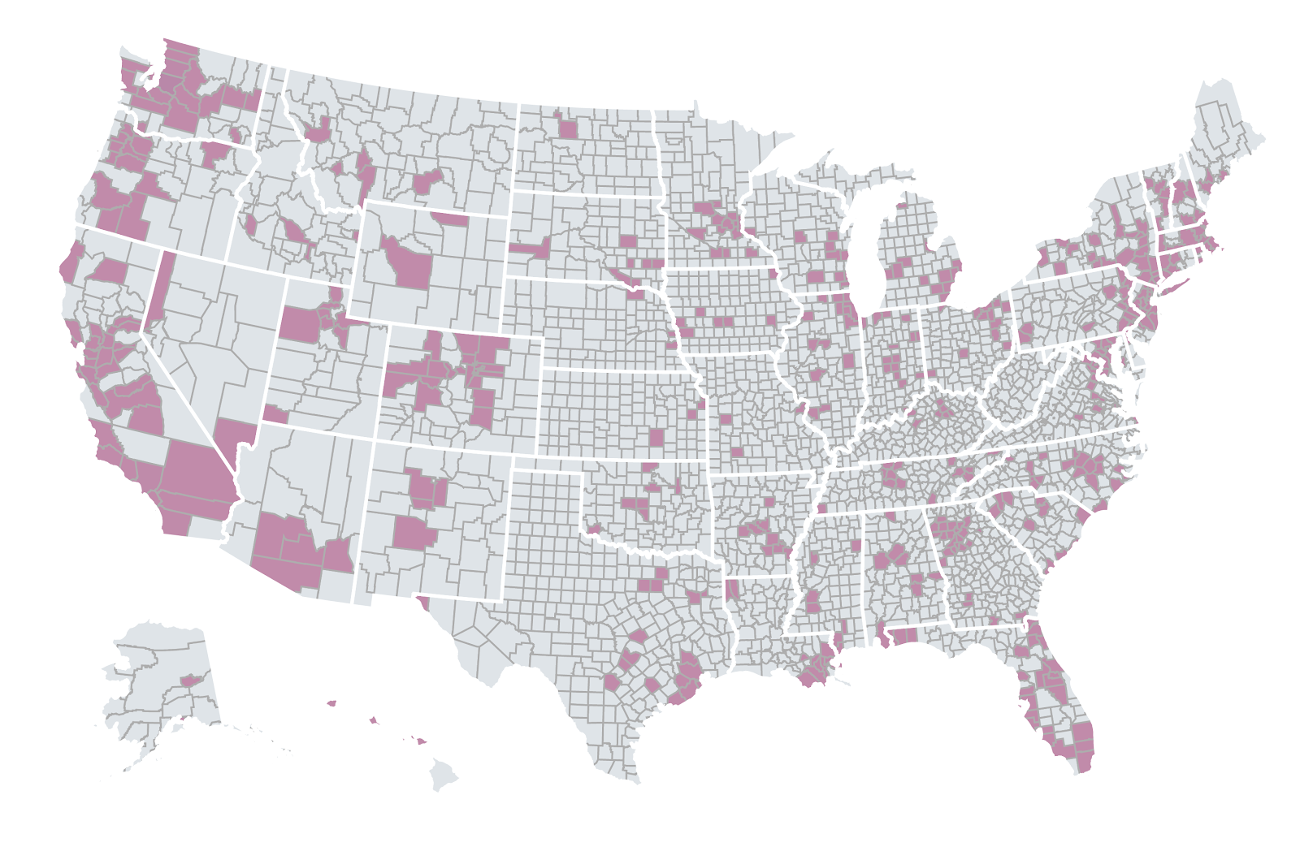

In [1]:
from IPython.display import Image
Image(filename='map.png') 

[Confirmed cases by county - March 16](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/)


To explain why a virus was detected, we then used publicly available social-economic data.  The resulting dataset has a row for every county, socio-economic data, and our target which is whether or not the county currently has detected COVID. The figure here shows a snapshot of the data, the full dataset can be downloaded [here](https://github.com/datarobot-community/learning-center-use-case-samples-wip/blob/master/python/predicting_covid_at_county_level/trainDatawithAirports.csv).

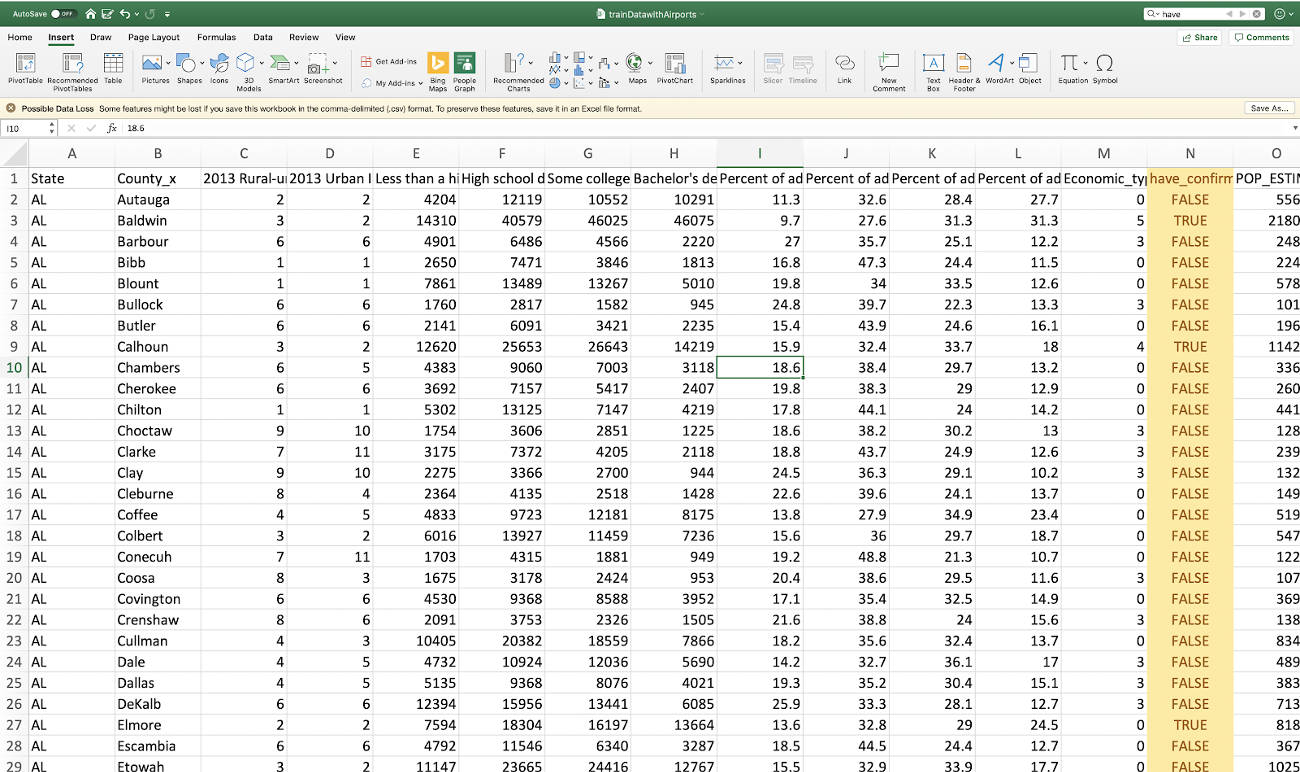

In [3]:
from IPython.display import Image
Image(filename='data.png') 


## Using Python to Model COVID-19 in DataRobot

This tutorial will cover how to recreate the modeling in DataRobot using the Python API.  You can find full documentation of the Python DataRobot package [here](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.19.0/).

### Import Packages

In [1]:
import datarobot as dr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

### Credentials

You may have your own way of doing this. I keep a local .py file that contains my credentials: DRToken = "token" and DREndpoint = "endpoint". 

In [ ]:
#!cat credentials.py
%run credentials.py #% signs in Jupyter are magic command: execute the python script (text file with tolken)
dr.Client(token = DRToken, endpoint = DREndpoint)
dr.client.get_client().endpoint
dr.client.get_client().token

In [3]:
df = pd.read_csv("trainDatawithAirports.csv")
df.head(5)

,State,County_x,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 2014-18","High school diploma only, 2014-18","Some college or associate's degree, 2014-18","Bachelor's degree or higher, 2014-18","Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18",...,CHRONIC DISEASE,CRITICAL ACCESS,GENERAL ACUTE CARE,LONG TERM CARE,MILITARY,PSYCHIATRIC,REHABILITATION,SPECIAL,WOMEN,NoOfAirports
0,AL,Autauga,2,2,4204,12119,10552,10291,11.3,32.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,AL,Baldwin,3,2,14310,40579,46025,46075,9.7,27.6,...,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0
2,AL,Barbour,6,6,4901,6486,4566,2220,27.0,35.7,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,AL,Bibb,1,1,2650,7471,3846,1813,16.8,47.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,AL,Blount,1,1,7861,13489,13267,5010,19.8,34.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


### Run Autopilot

In [ ]:
project = dr.Project.start(project_name='COVID_19_Geographical',
                        sourcedata= df,
                        target='have_confirmed_18')

project.wait_for_autopilot() #Wait for autopilot to complete

### Select the Best Model

In [3]:
project = dr.Project.get(project_id='YOUR_PROJECT_ID')
project.id
project


Project(COVID_19_Geographical)

In [4]:
models = project.get_models(order_by = '-metric')


for model in models[-5:]:
    print(model)
    print(model.metrics['LogLoss']['validation'])

Model('Auto-tuned K-Nearest Neighbors Classifier (Euclidean Distance)')
0.35798
Model('Naive Bayes combiner classifier')
0.36684
Model('Isolation Forest Anomaly Detection')
0.41993
Model('Majority Class Classifier')
0.48167
Model('Decision Tree Classifier (Gini)')
1.19655


In [5]:
model = models[0]
model

Model('eXtreme Gradient Boosted Trees Classifier')

This gives us a model that learns the common patterns between socio-economic factors and COVID.  The next step is using the model to get predictions on all the counties that do not have COVID.  The counties with the highest predictions are known as “look-alike” counties, because they share similar characteristics as the counties that have COVID.  


## Evaluating the Performance

Using DataRobot, we were easily able to build a model that did a good job of identifying which counties were likely to have COVID.  During our model development process, we built models on time-stamped data and then checked predictions over the next 10 days.  If we look at the top 50 highest predictions out of the model, 48 of those counties had a COVID case within the next ten 10 days.  In other words, the models had a 88% precision rate for a five-day forecast, with an increase to 96% over a 10-day forecast window based on the top 50 predictions. 


## Explaining the Model

Interpretability tools allow us to next start understanding how the model was using all these socio-economic features.  At a broad level, we found that regions with larger populations, higher median income, and a higher level of education are more susceptible to infections in the early outbreak of the coronavirus.  The **feature impact plot** shows what features are most important to the model.  Immediately we see income and education right at the top of this plot


### Feature Impact

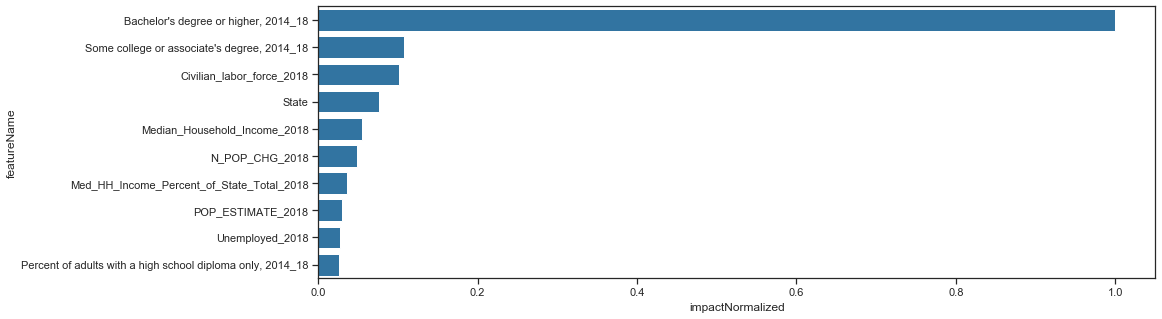

In [131]:
#Get Feature Impact
feature_impact = model.get_or_request_feature_impact()

#Save feature impact in pandas dataframe
fi_df = pd.DataFrame(feature_impact)

#Plot feature impact
blue = '#1F77B4'
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(x='impactNormalized', y='featureName', data=fi_df[0:10], orient = 'h', color=blue)

### Partial Dependence

To understand the patterns in features like income, we use tools like the feature effects plot below.  This shows us a stark divide between low income, which had a less likelihood of having a COVID in their county, and other groups.  


In [7]:
#calculate feature effects
feature_effects = model.request_feature_effect()
feature_effects.wait_for_completion() #Wait till feature effects computes

#get results
temp_pd = list(feature_effects.get_result())

#select best feature
best_feature = fi_df.loc[fi_df['impactNormalized'] == 1, 'featureName']
best_feature[0]

"Bachelor's degree or higher, 2014_18"

In [21]:
#find the best feature partial dependence data
i = 0
length = len(temp_pd) 

while i < length: 
    if temp_pd[i]['feature_name'] == "Bachelor's degree or higher, 2014_18":
        fe = (temp_pd[i])
        #print(fe)
    i = i + 1


In [106]:
#put this into a dataframe
partial_dependence_data = fe['partial_dependence']['data']
partial_dependence_data_df = pd.DataFrame(partial_dependence_data) 
partial_dependence_data_df.columns = ['target_probability','value']
partial_dependence_data_df.head(5)


,target_probability,value
0,267.7,0.046466
1,319.28,0.046466
2,363,0.046466
3,399.56,0.046466
4,444.4000000000001,0.046466


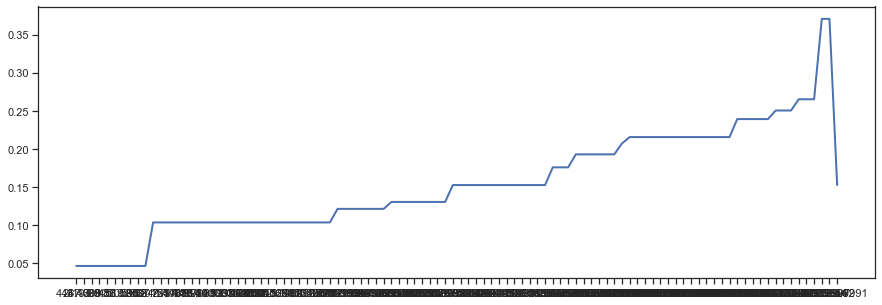

In [108]:
plt.figure(figsize=(15,5))
plt.plot(partial_dependence_data_df.target_probability, partial_dependence_data_df.value, linewidth=2.0)



Finally, we also examined the risk by county.  Using explanations, it’s possible to see what features contribute to the likelihood of COVID by county.  In this example, we see that education is playing a strong role in making this county have a very high likelihood of COVID.  And again, this makes sense with what we know about COVID and its spreads through higher income groups that are more likely traveling and exposed to more possible carriers.  

### Prediction Explanations

In [109]:
# Initialize prediction explanations
pei_job = dr.PredictionExplanationsInitialization.create(project.id, model.id) 
pei_job.wait_for_completion()


In [ ]:
# Upload prediction data
dataset = project.upload_dataset('./data_to_predict.csv')

In [130]:
# Generate and get Prediction Explanations for Dataset
predict_job = model.request_predictions(dataset.id)
predict_job.wait_for_completion()

pe_job = dr.PredictionExplanations.create(project.id, model.id, dataset.id)
pe = pe_job.get_result_when_complete()

row.prediction_explanations

[{'label': 1.0,
  'feature': "Bachelor's degree or higher, 2014_18",
  'feature_value': 961,
  'strength': -0.556759965304614,
  'qualitative_strength': '---'},
 {'label': 1.0,
  'feature': 'State',
  'feature_value': 'WY',
  'strength': 0.36338654980632024,
  'qualitative_strength': '+++'},
 {'label': 1.0,
  'feature': 'Civilian_labor_force_2018',
  'feature_value': 3731,
  'strength': -0.2528846446591144,
  'qualitative_strength': '--'}]

Our belief is this model worked because initial infections were determined mainly by population mobility (especially international mobility) which strongly correlates with social-economic factors.  (See the NY Times story on Party 0).  


## Predicting on New Counties 

To get predictions from this model, we use a concept of stacked predictions to get out of sample predictions.  The model here has been trained based on all the county data.  It would be poor data science practice to get predictions on the same data the model has been trained on (in-sample predictions).  This is simply because the model might “cheat” by using the answer (whether or not the county has COVID) at the time of prediction.  To avoid these issues, we use a sophisticated setup where we build multiple models on separate parts of the training data.  Then when making predictions, we ensure that a model has not used the same data during training.  This technique for getting out of sample predictions is called stacked predictions.  It is widely used in Kaggle competitions to try and squeeze all the possible information out of some data.  This technique is also built into DataRobot and the out of sample predictions are available for any model.  

The next step after getting all the out-of-sample predictions is to remove records for actual positives.  After all, those counties have test positive and aren’t of interest.  Finally, we sort the remaining counties by the score.  The counties at the top have the highest likelihood of having COVID, because they are most similar to the positive class. 

